In [3]:
IDENTIFIER = "beethoven-op67"
NUM = 4

import networkx as nx
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import re
from music21 import converter

from dwave.system import DWaveSampler, FixedEmbeddingComposite

from plots import plotHistogram, plotSampleGraph, plotCSV
from scores import composeArrangement
from qubo import createBQM
from samples import overlaps, duplicates

path = f"../Pickles/{IDENTIFIER}/{IDENTIFIER}_"
numPath = f"../Pickles/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"
dataPath = f"../Data/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"

score = converter.parse(path + "score.musicxml")
phrases = pd.read_csv(path + "phrases.csv", index_col=[0,1])
G = nx.read_graphml(path + "graph.graphml")
instruments = json.load(open(numPath + "instruments.json"))
embedding = json.load(open(numPath + "embedding.json", "r"))

sampler = FixedEmbeddingComposite(DWaveSampler(), embedding)

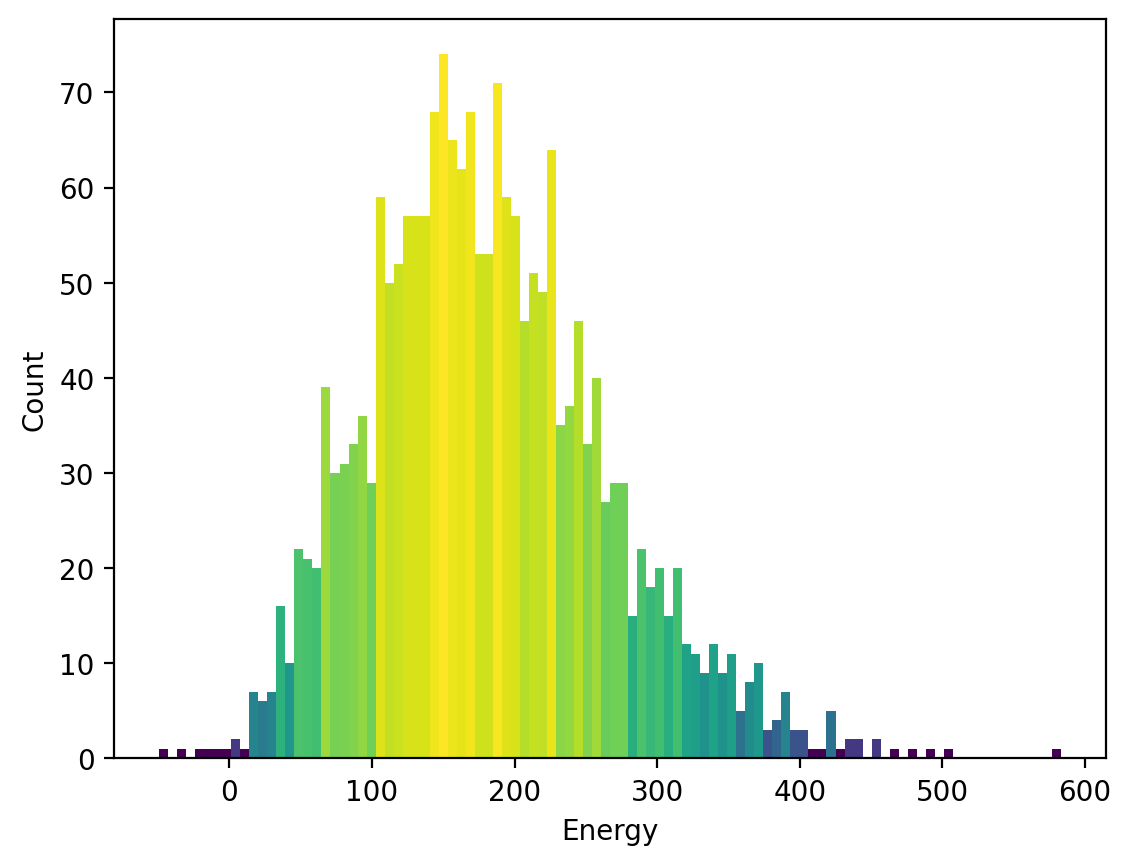

In [2]:
bqm = createBQM(G, phrases, instruments, 6, 12, 1)
r = 2000
cs = 30
at = 200
sampleset = sampler.sample(bqm, num_reads=r, chain_strength=cs, annealing_time=at, label=f"{IDENTIFIER}_{r}_{cs}_{at}us")
plotHistogram(sampleset.to_pandas_dataframe(True))


In [8]:
sampleset.to_pandas_dataframe(True).to_csv(dataPath + "sampleset.csv")

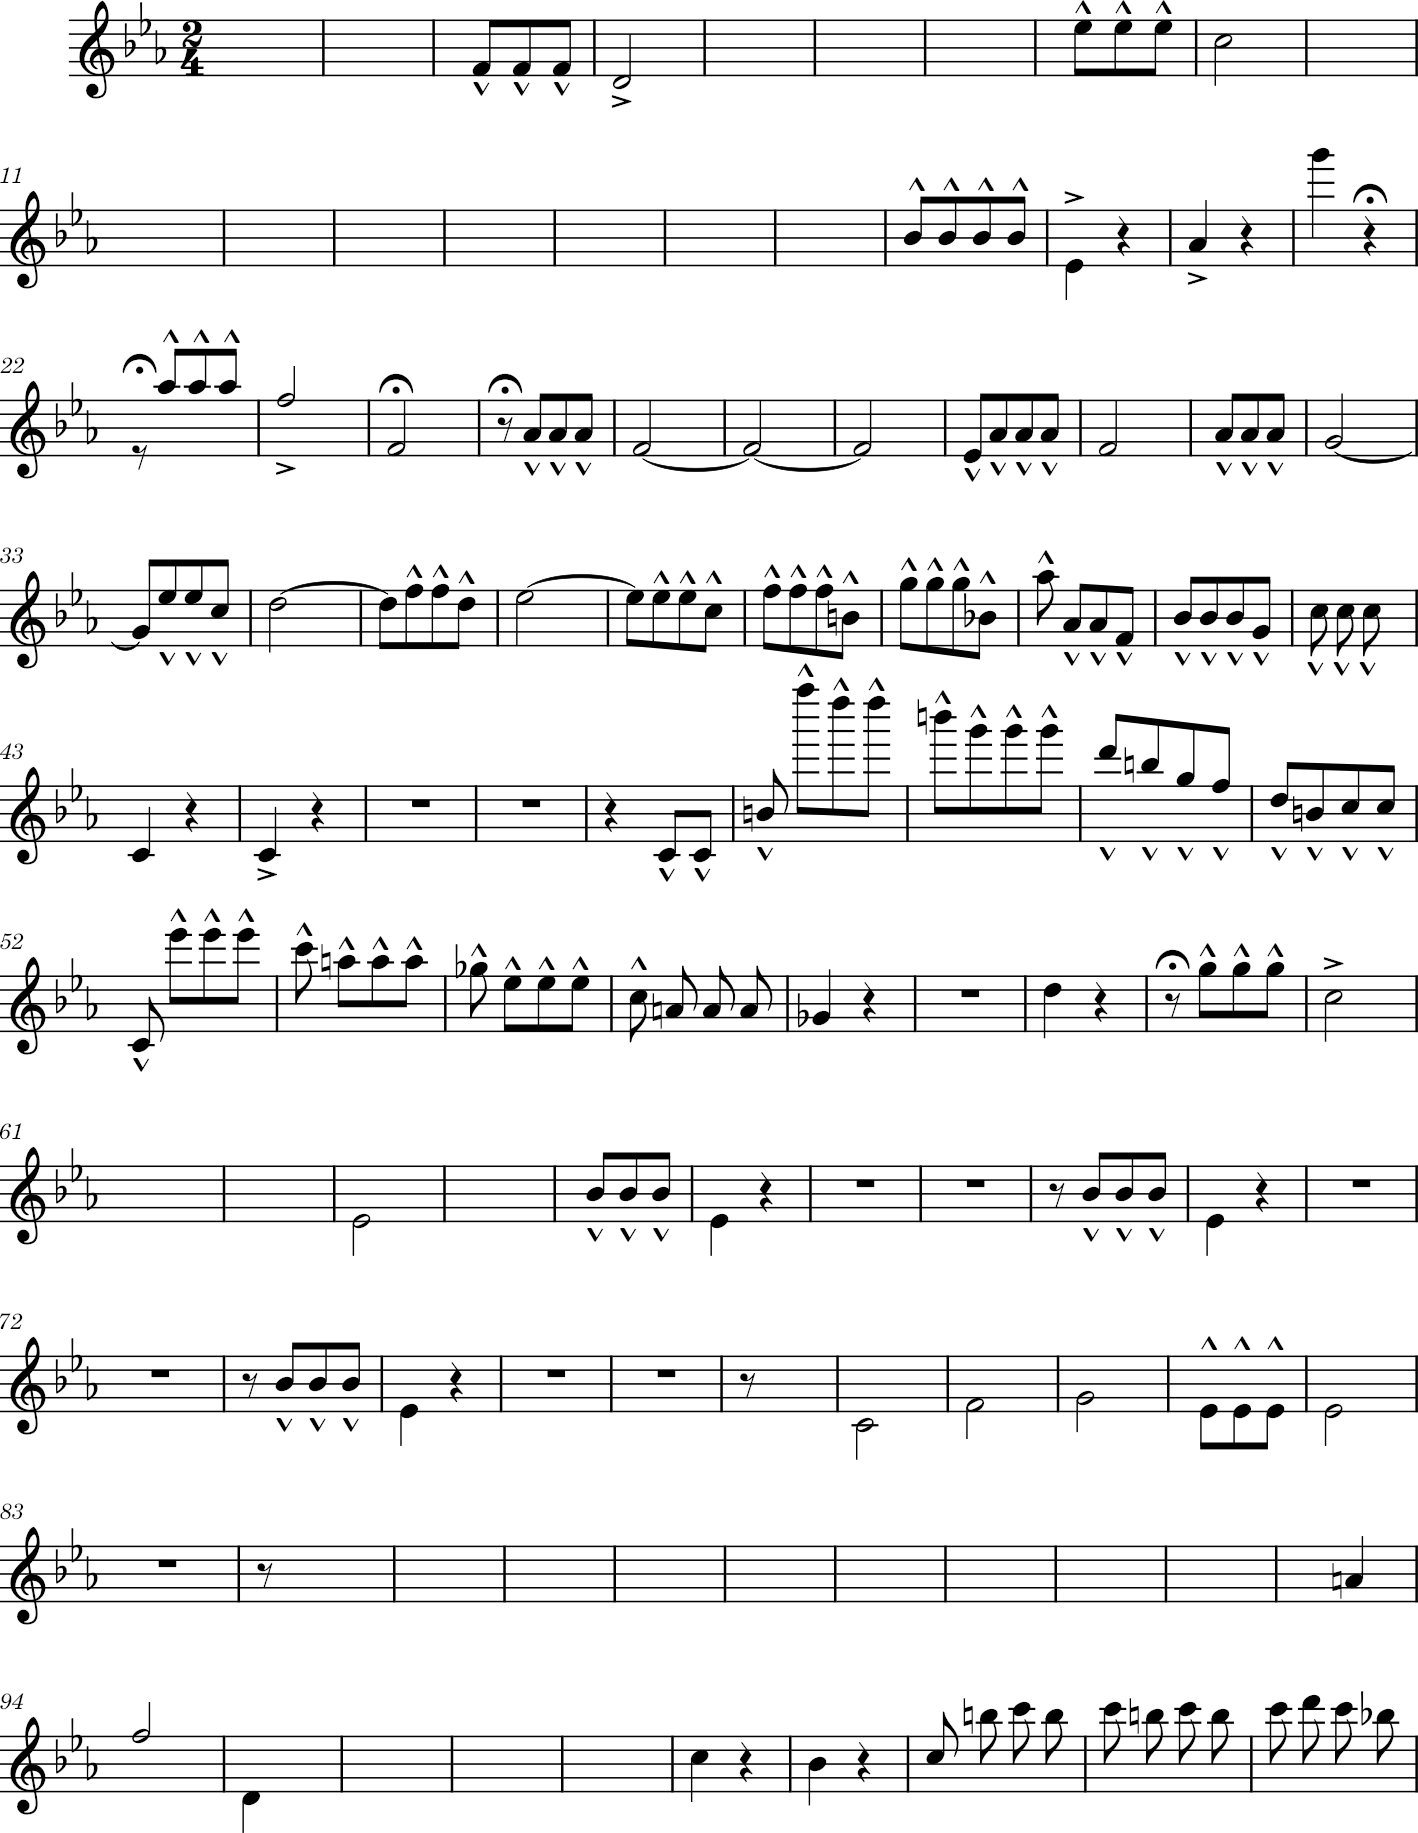

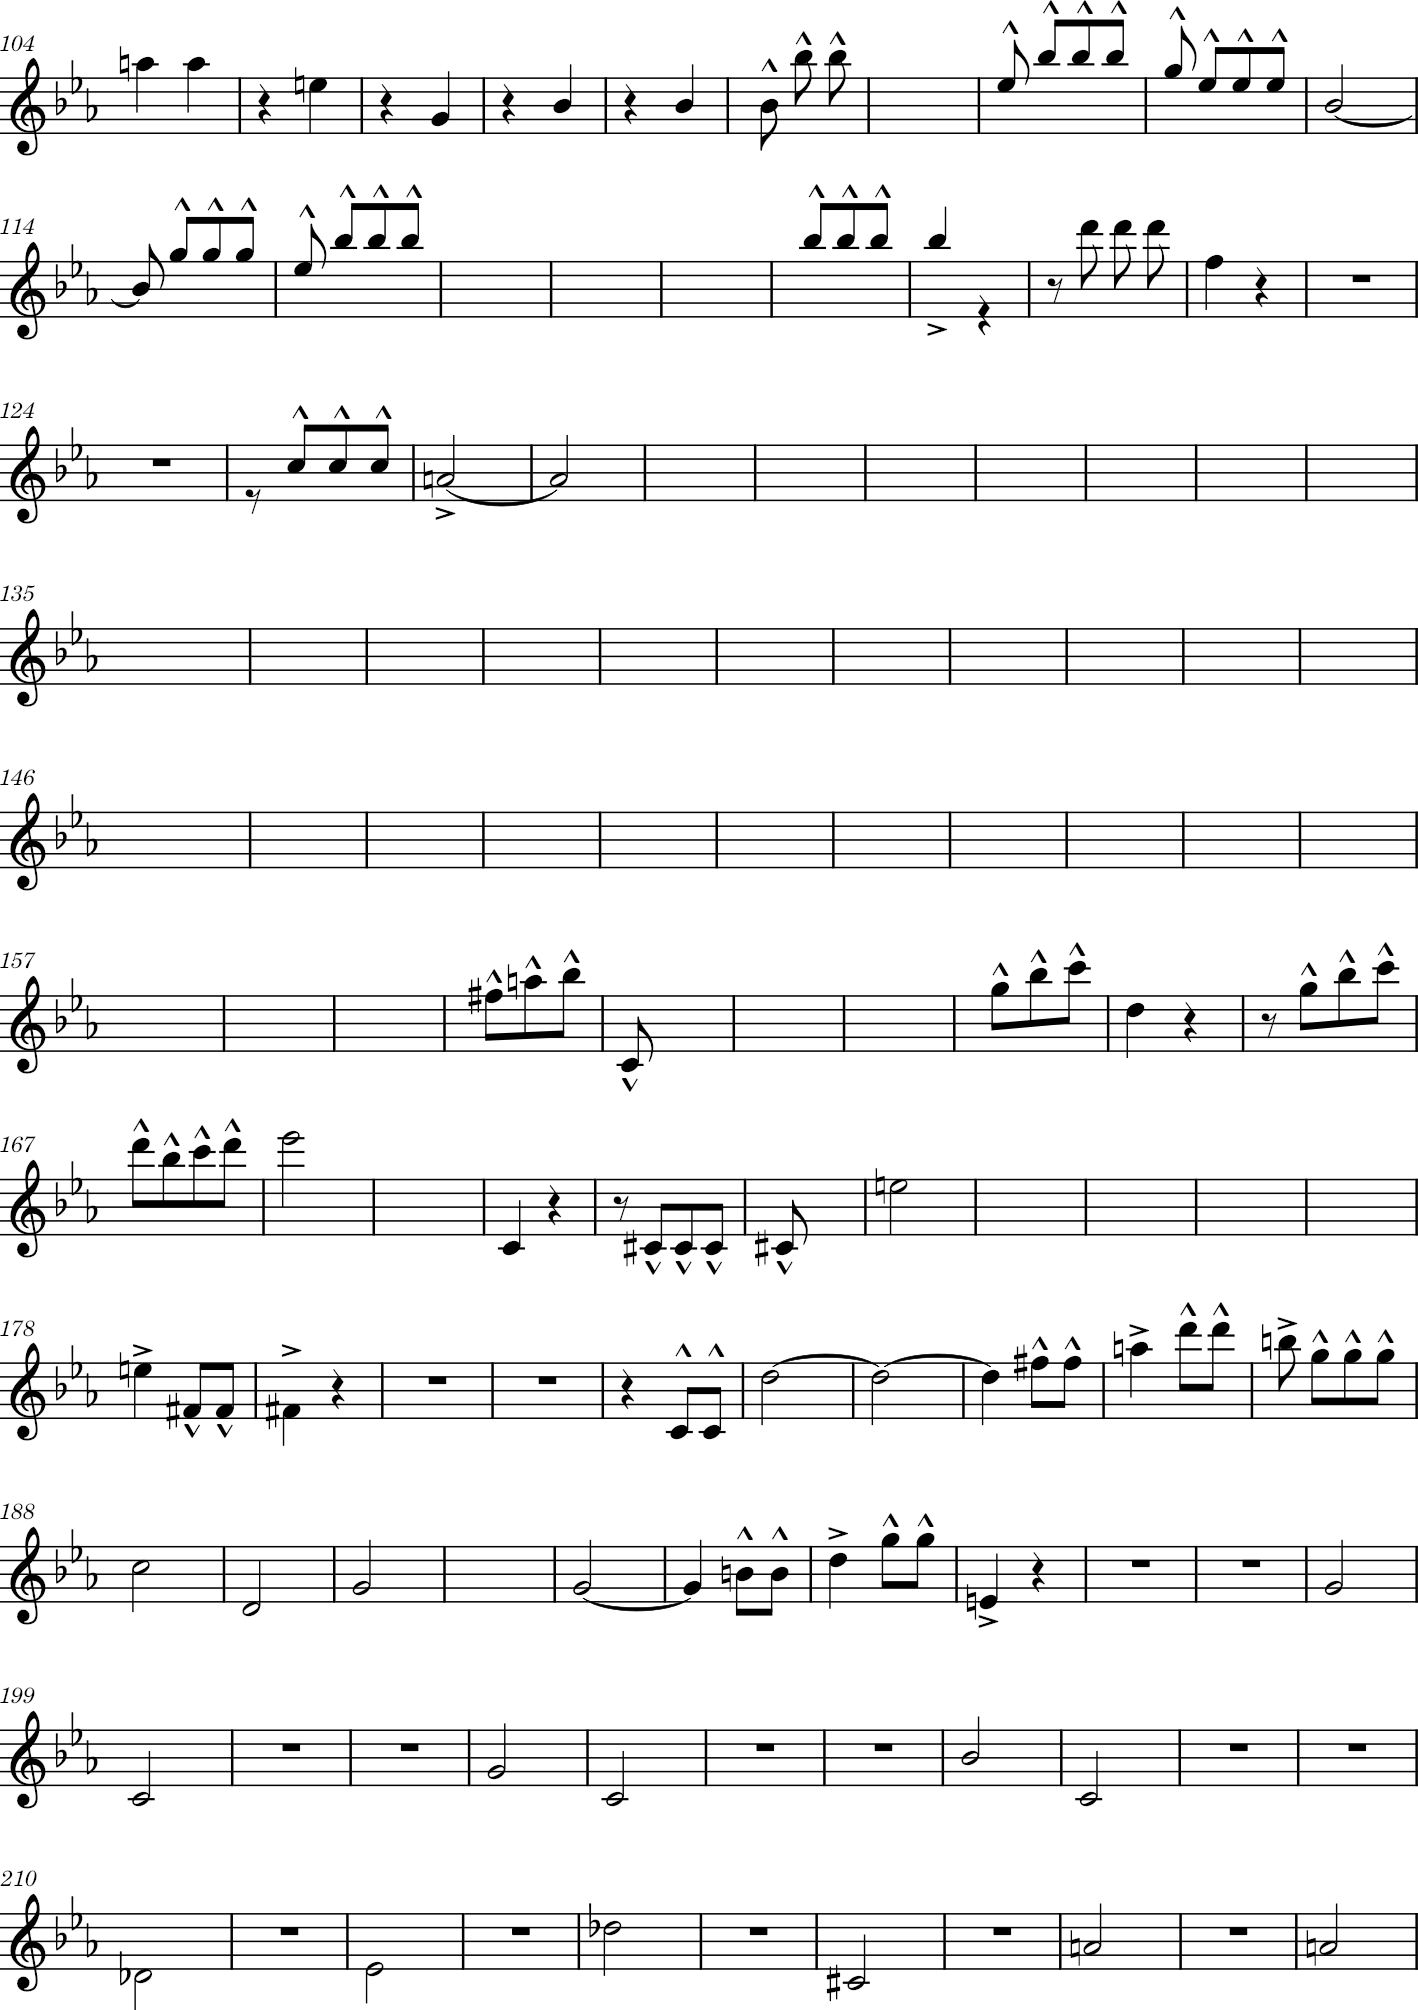

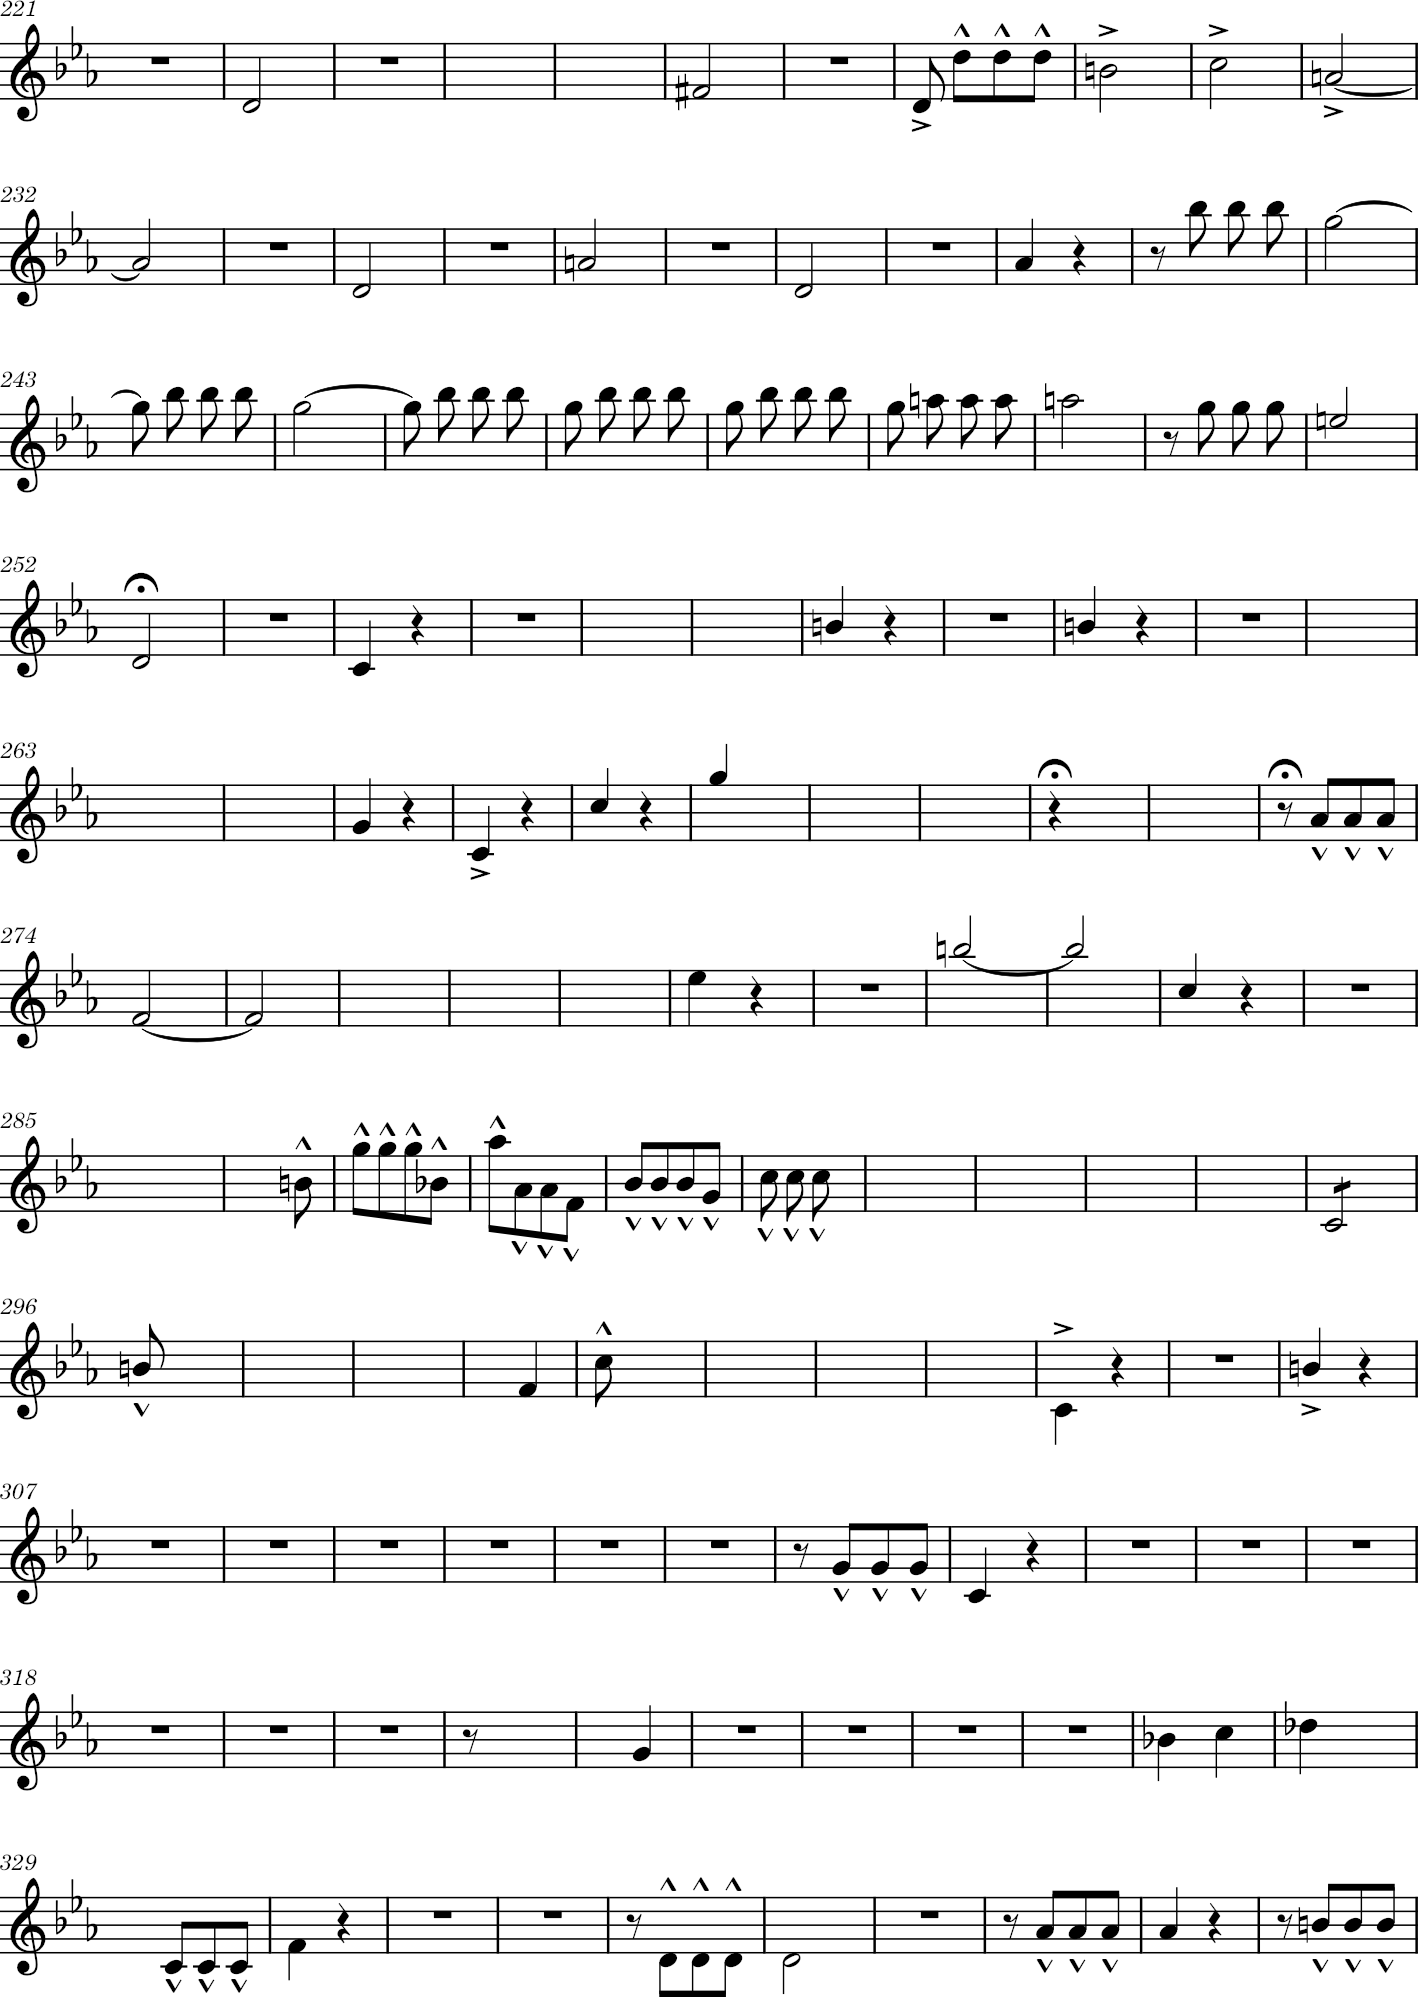

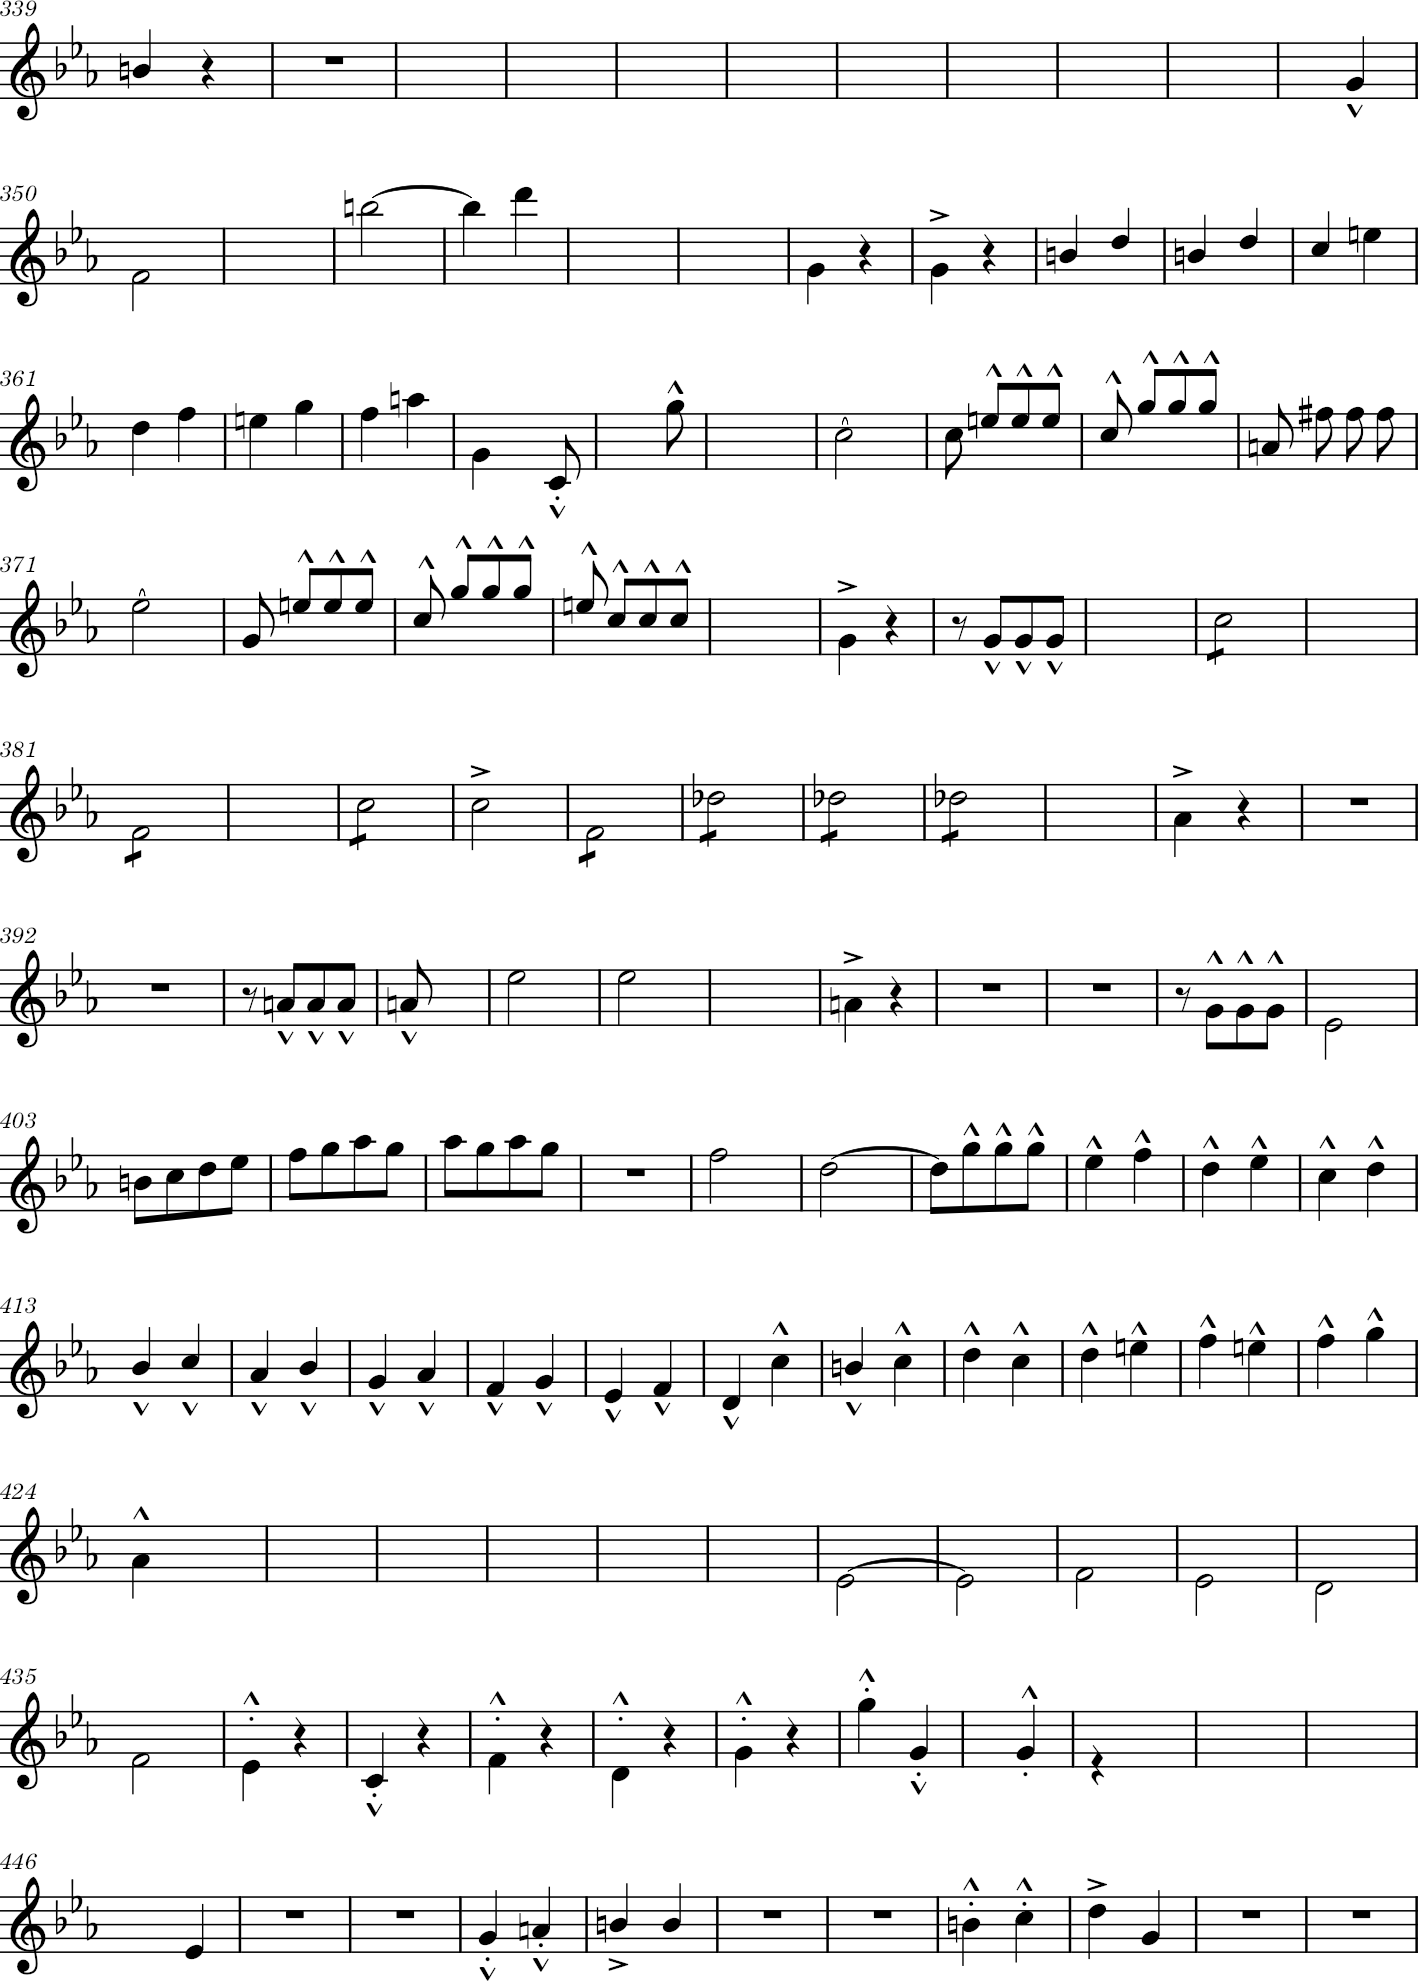

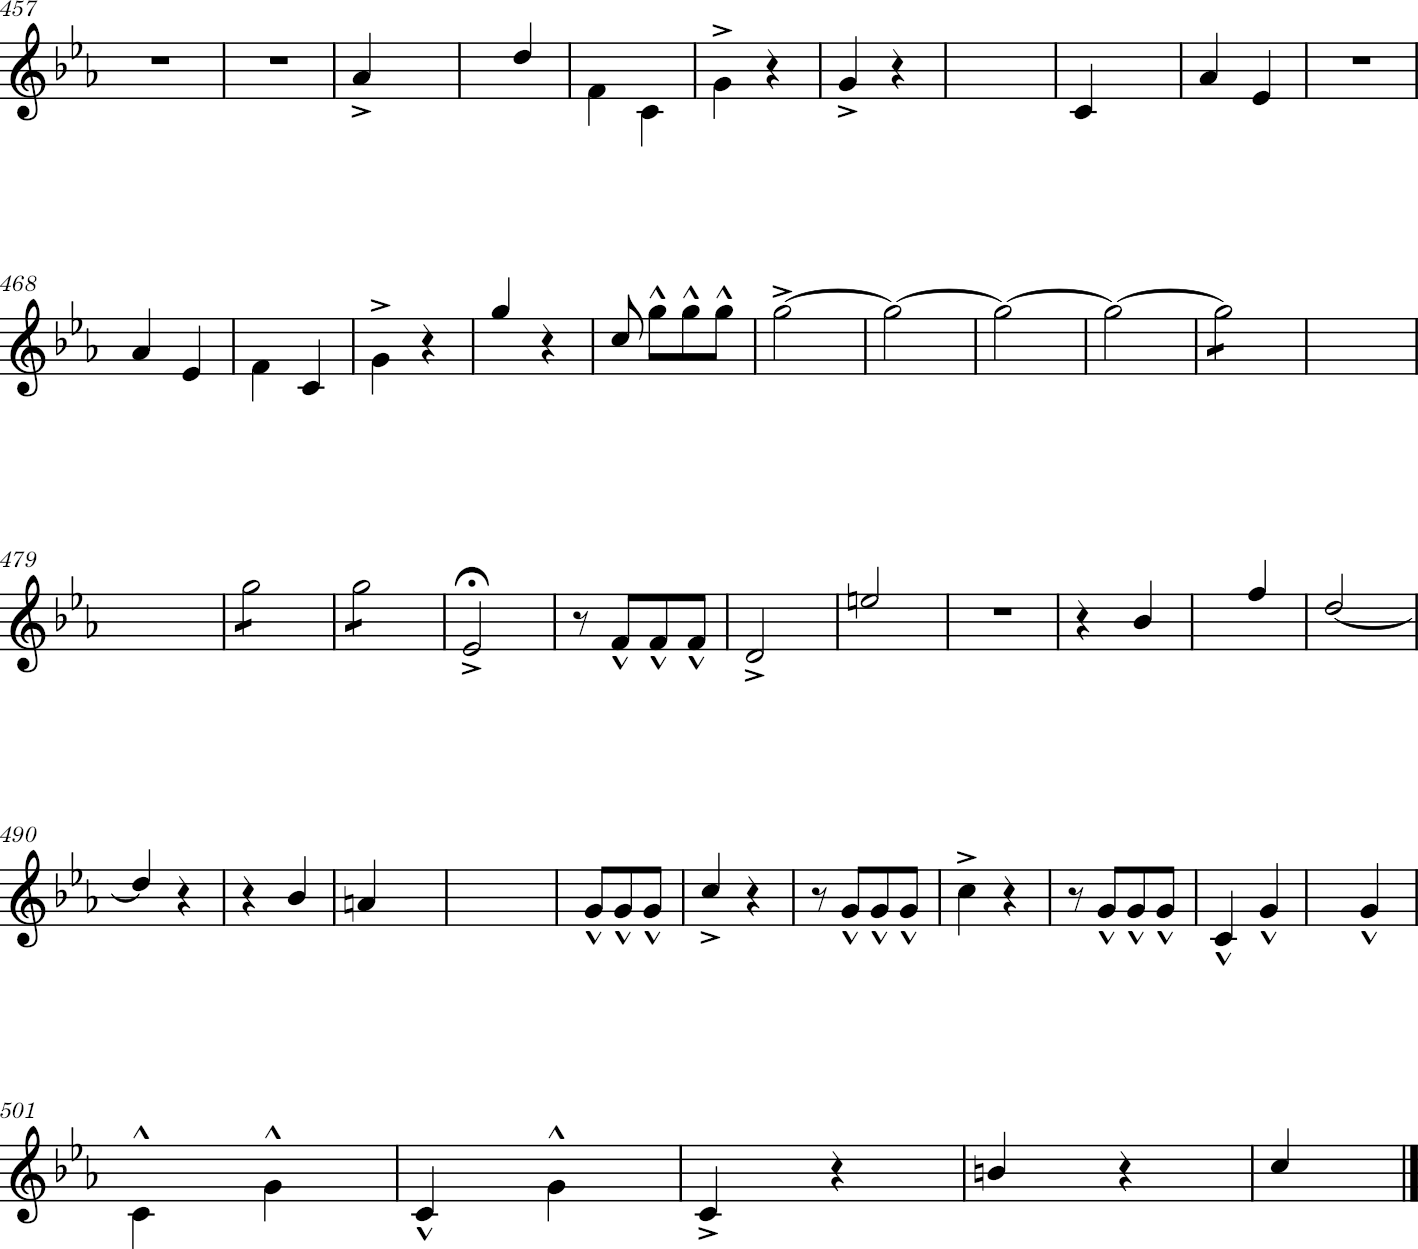

In [18]:
#print(sampleset.first.sample)
#print(extractChosen(sampleset.first.sample))
#plotSampleGraph(sampleset.first.sample, G, instruments)

arr = composeArrangement(sampleset.first.sample, score, phrases, instruments, "test.mid")
arr.show()

In [7]:
def duplicates(sample: dict) -> list:
    
    pattern = r"^(.+_\d+)_.+$"
    return [n for n in G.nodes if sum(sample[k] for k in sample if re.match(pattern, k).group(1) == n) > 1]

multipliers = np.arange(1,6.5,.5)

file = pd.DataFrame()
for m in multipliers:
    bqm = createBQM(G, phrases, instruments, m, 1, 1)
    sampleset = sampler.sample(bqm, num_reads=1000, label=f"Haydn_{1000}")
    sample = sampleset.first

    new_row = pd.DataFrame({
        "Multiplier": [m],
        "Lowest energy": [bqm.energy(sample.sample)],
        "Chain break fraction": [sample.chain_break_fraction],
        "Duplicates": [len(duplicates(sample.sample))]
        })
    
    file = pd.concat([file, new_row])
    
    print(f"Multiplier {m} recorded!")

file.to_csv(path+"node-constraint.csv", index=False, mode="a", header=False)

Multiplier 1.0 recorded!
Multiplier 1.5 recorded!
Multiplier 2.0 recorded!
Multiplier 2.5 recorded!
Multiplier 3.0 recorded!
Multiplier 3.5 recorded!
Multiplier 4.0 recorded!
Multiplier 4.5 recorded!
Multiplier 5.0 recorded!
Multiplier 5.5 recorded!
Multiplier 6.0 recorded!


In [ ]:
plotCSV(path+"simulated.csv", "Total reads", "Lowest energy", np.arange(1000,20000,1000))

In [ ]:
# QPU

no_reads = range(6000, 20001, 1000)
max_reads = 3000

bqm = createBQM(G, phrases, instruments, 1, 12, 1)

for total_reads in no_reads:

    if total_reads <= max_reads:
        sampleset = sampler.sample(bqm, num_reads=total_reads, label=f"Haydn_{total_reads}")
    
    else:
        sampleset = sampler.sample(bqm, num_reads=max_reads, label=f"Haydn_{total_reads}_{max_reads}")
        reads = total_reads - max_reads

        while reads > 0:
            if reads <= max_reads:
                new_sampleset = sampler.sample(bqm, num_reads=reads, label=f"Haydn_{total_reads}_{reads}")
                reads = 0

            else:
                new_sampleset = sampler.sample(bqm, num_reads=max_reads, label=f"Haydn_{total_reads}_{max_reads}")
                reads -= max_reads

            if new_sampleset.first.energy < sampleset.first.energy:
                sampleset = new_sampleset

    A = annotateSampleGraph(sampleset.first.sample, G)

    new_row = pd.DataFrame({
        "Total reads": [total_reads],
        "Chain strength": [sampleset.info["embedding_context"]["chain_strength"]],
        "Anneal time": [sampleset.info["timing"]["qpu_anneal_time_per_sample"]],
        "QPU time": [sampleset.info["timing"]["qpu_access_time"]],
        "Lowest energy": [bqm.energy(sample.sample)],
        "Chain break fraction": [sampleset.first.chain_break_fraction],
        "Overlaps": [findOverlaps(A)],
        "Total entropy": [totalEntropy(A)]
        })

    new_row.to_csv(path+"total-reads.csv", index=False, mode="a", header=False)
    print(f"Recorded {total_reads} reads")

In [ ]:
print(sampleset.info.keys())
print(sampleset.info["embedding_context"]["chain_strength"])
print(sampleset.info["timing"]["qpu_anneal_time_per_sample"])
print(sampleset.info["timing"]["qpu_access_time"])
print(sampleset.info["timing"])
print(sampleset.first.energy)
print(bqm.energy(sampleset.first.sample))
print(sampleset.first.sample)
print(sampleset.first.chain_break_fraction)

In [ ]:

#arrangement.write(fmt="musicxml.pdf", fp="../Figures/poly.pdf", dpi=300)

# DONE: Bias selection of phrases to specific parts by entropy
# DONE: Octave shift phrases to fit within instrument ranges
# TODO: Analytic Lagrange parameter analysis
# TODO: Add meaningful edge weightings
# TODO: Are there more efficient ways to add constraints?

# TODO: Solution quality against problem size
# TODO: Number of qubits (in embedding) against problem size
# TODO: Time to solution against problem size